In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter # Make sure this is imported if running cell independently

# --- Load the preprocessed data if running this cell independently ---
PROCESSED_DATA_DIR = '../data/processed_data/'
preprocessed_file = os.path.join(PROCESSED_DATA_DIR, 'nasa_battery_data_preprocessed.csv')
try:
    df = pd.read_csv(preprocessed_file)
    print("Loaded preprocessed data.")
except FileNotFoundError:
    print(f"Error: Preprocessed file not found at {preprocessed_file}. Ensure the previous cells ran.")
    df = None

Loaded preprocessed data.


In [2]:
df

,battery_id,cycle_number,cycle_type,ambient_temperature,measurement_time_relative,voltage_measured,current_measured,temperature_measured,voltage_load_or_charge,current_load_or_charge,capacity,initial_capacity,soh,voltage_measured_smooth,current_measured_smooth,temperature_measured_smooth
0,B0005,1,charge,24,0.000,3.873017,-0.001201,24.655358,0.003,0.0000,NaN,1.856487,NaN,3.725090,-1.459122,24.653435
1,B0005,1,charge,24,2.532,3.479394,-4.030268,24.666480,1.570,-4.0360,NaN,1.856487,NaN,3.808583,-0.602013,24.666549
2,B0005,1,charge,24,5.500,4.000588,1.512731,24.675394,4.726,1.5000,NaN,1.856487,NaN,3.880187,0.124619,24.679553
3,B0005,1,charge,24,8.344,4.012395,1.509063,24.693865,4.742,1.5000,NaN,1.856487,NaN,3.939903,0.720772,24.692448
4,B0005,1,charge,24,11.125,4.019708,1.511318,24.705069,4.753,1.5000,NaN,1.856487,NaN,3.987730,1.186448,24.705234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497585,B0018,319,discharge,24,2686.359,3.443760,-0.002426,35.383979,0.000,0.0006,1.341051,1.855005,0.722937,3.444211,-0.000369,35.387152
1497586,B0018,319,discharge,24,2700.546,3.453271,-0.000981,35.179732,0.000,0.0006,1.341051,1.855005,0.722937,3.453753,-0.000323,35.180418
1497587,B0018,319,discharge,24,2714.640,3.461963,0.000209,34.977000,0.000,0.0006,1.341051,1.855005,0.722937,3.462342,-0.000317,34.977737
1497588,B0018,319,discharge,24,2728.750,3.469907,0.001516,34.785943,0.000,0.0006,1.341051,1.855005,0.722937,3.469976,-0.000352,34.779109


In [5]:

# --- Or ensure 'df' exists from previous cells ---
if 'df' not in locals() or df is None:
     raise ValueError("DataFrame 'df' not found. Please run the previous cells in the notebook.")

# Define visualization directory if not defined
if 'VISUALIZATION_DIR' not in locals():
    VISUALIZATION_DIR = '../visualizations/'
    os.makedirs(VISUALIZATION_DIR, exist_ok=True)
if 'PROCESSED_DATA_DIR' not in locals():
     PROCESSED_DATA_DIR = '../data/processed_data/' # Define if not set


# --- Add this cell to verify cycle counts ---
print("\n--- Verifying Max Cycle Numbers in the DataFrame ---")
if df is not None:
    max_cycles = df.groupby('battery_id')['cycle_number'].max()
    print("Maximum cycle number per battery_id found in 'df':")
    print(max_cycles)

    # Specifically check B0005
    if 'B0005' in max_cycles.index:
        max_b0005 = max_cycles.loc['B0005']
        print(f"\nMax cycle for B0005: {max_b0005}")
        if max_b0005 > 180: # Allow a little margin over 168
            print("\n*** WARNING: Max cycle for B0005 seems too high compared to the standard NASA dataset. Please check your initial data source and preprocessing steps. ***")
    else:
        print("\nBattery B0005 not found in the DataFrame.")
else:
    print("DataFrame 'df' is not loaded.")
# --- End verification cell ---

print("\n--- 7. Feature Extraction - TIEDVD (Time Interval of Equal Discharging Voltage Difference) ---")

# Voltages defined in the paper (Section 6.1, Figure 8b explanation)
V_HIGH = 3.8
V_LOW = 3.4
VOLTAGE_COLUMN = 'voltage_measured_smooth' # Use smoothed voltage for stability
TIME_COLUMN = 'measurement_time_relative'

def calculate_tiedvd_for_cycle(cycle_df):
    """
    Calculates the time difference between voltage dropping below V_HIGH
    and V_LOW during a single discharge cycle.

    Args:
        cycle_df (pd.DataFrame): DataFrame for a single discharge cycle,
                                 sorted by time.

    Returns:
        float: Calculated TIEDVD for the cycle, or np.nan if thresholds aren't met.
    """
    # Ensure data is sorted by time (should be by groupby application, but double-check)
    cycle_df = cycle_df.sort_values(by=TIME_COLUMN)

    # Find the first time voltage drops <= V_HIGH
    high_voltage_point = cycle_df[cycle_df[VOLTAGE_COLUMN] <= V_HIGH]
    if high_voltage_point.empty:
        # print(f"Debug: Cycle did not reach {V_HIGH}V.")
        return np.nan
    time_at_v_high = high_voltage_point.iloc[0][TIME_COLUMN]
    index_at_v_high = high_voltage_point.index[0] # Index in the original slice

    # Find the first time voltage drops <= V_LOW *starting from or after* the V_HIGH point
    low_voltage_point = cycle_df.loc[index_at_v_high:][cycle_df[VOLTAGE_COLUMN] <= V_LOW]
    if low_voltage_point.empty:
        # print(f"Debug: Cycle did not reach {V_LOW}V after reaching {V_HIGH}V.")
        return np.nan
    time_at_v_low = low_voltage_point.iloc[0][TIME_COLUMN]

    # Calculate the difference (should be non-negative if logic is correct)
    tiedvd = time_at_v_low - time_at_v_high

    # Return NaN if calculated difference is not positive (shouldn't happen with this logic)
    return tiedvd if tiedvd > 0 else np.nan

# --- Apply the function ---
# Filter only discharge cycles for calculation
discharge_df_only = df[df['cycle_type'] == 'discharge'].copy()

# Apply the function to each group (each discharge cycle for each battery)
print("Calculating TIEDVD for each discharge cycle...")
tiedvd_series = discharge_df_only.groupby(['battery_id', 'cycle_number']).apply(calculate_tiedvd_for_cycle)
tiedvd_series.name = 'tiedvd' # Name the resulting series

# Convert the multi-index series to a DataFrame for merging
tiedvd_df = tiedvd_series.reset_index()

print(f"Calculated TIEDVD for {len(tiedvd_df[tiedvd_df['tiedvd'].notna()])} discharge cycles (out of {len(tiedvd_df)}).")
print("Sample TIEDVD values:")
print(tiedvd_df.head())
print("\nTIEDVD stats:")
print(tiedvd_df['tiedvd'].describe())

# Merge the calculated TIEDVD back into the main DataFrame based on battery and cycle
print("\nMerging TIEDVD values back into the main DataFrame...")
df = pd.merge(df, tiedvd_df, on=['battery_id', 'cycle_number'], how='left')

# --- Optional: Propagate TIEDVD to all rows within the same cycle ---
# If you want the TIEDVD value available on charge/impedance rows too
# print("Propagating TIEDVD value within each cycle...")
# df['tiedvd'] = df.groupby(['battery_id', 'cycle_number'])['tiedvd'].transform(lambda x: x.ffill().bfill())


print("\nTIEDVD feature added to the main DataFrame.")
print("DataFrame Head showing TIEDVD:")
print(df[['battery_id', 'cycle_number', 'cycle_type', 'soh', 'tiedvd']].head(10))
print("\nChecking a discharge cycle (e.g., B0005, Cycle 2):")
print(df[(df['battery_id'] == 'B0005') & (df['cycle_number'] == 2)][[TIME_COLUMN, VOLTAGE_COLUMN, 'tiedvd']].head())

# --- 8. Create Summary DataFrame for Modeling ---
print("\n--- Creating Summary DataFrame (One Row Per Discharge Cycle) ---")

# Aggregate data: We need one row per discharge cycle containing the HI (TIEDVD) and the target (SoH)
# SoH is typically associated with the end of the discharge cycle.
# TIEDVD is constant for the whole discharge cycle.
# Use 'first' aggregation as SoH and TIEDVD should be consistent within a valid cycle group after potential propagation.
cycle_summary = df[df['cycle_type'] == 'discharge'].groupby(['battery_id', 'cycle_number']).agg(
    soh=('soh', 'first'), # Assuming SoH was correctly propagated or is consistent
    tiedvd=('tiedvd', 'first') # TIEDVD is constant for the cycle
).reset_index()

# Drop cycles where TIEDVD or SoH could not be calculated (are NaN)
initial_rows = len(cycle_summary)
cycle_summary.dropna(subset=['tiedvd', 'soh'], inplace=True)
rows_after_drop = len(cycle_summary)
if initial_rows > rows_after_drop:
    print(f"Dropped {initial_rows - rows_after_drop} cycles due to missing TIEDVD or SoH values.")

print(f"\nFinal Cycle Summary DataFrame shape: {cycle_summary.shape}")
print("Cycle Summary DataFrame Head:")
print(cycle_summary.head())
print("\nCycle Summary DataFrame Tail:")
print(cycle_summary.tail())
print("\nCycle Summary Info:")
cycle_summary.info()

# --- 9. Save the Final Cycle Summary Data ---
summary_output_file = os.path.join(PROCESSED_DATA_DIR, 'nasa_battery_cycle_summary.csv')
print(f"\nSaving cycle summary data (input for model) to {summary_output_file}...")
try:
    cycle_summary.to_csv(summary_output_file, index=False)
    print("Save complete.")
    print(f"\nThis file '{os.path.basename(summary_output_file)}' should be used as input for your CNN-BiLSTM-AM model training script.")
except Exception as e:
    print(f"Error saving cycle summary DataFrame: {e}")

# --- Optional: Visualize TIEDVD vs SoH ---
print("\nVisualizing TIEDVD vs SoH...")
plt.figure(figsize=(10, 6))
for batt_id in cycle_summary['battery_id'].unique():
    subset = cycle_summary[cycle_summary['battery_id'] == batt_id]
    plt.scatter(subset['cycle_number'], subset['tiedvd'], label=f'{batt_id} - TIEDVD', alpha=0.7, s=10)
    plt.scatter(subset['cycle_number'], subset['soh'] * subset['tiedvd'].mean() * 1.1, label=f'{batt_id} - SoH (scaled)', marker='x', alpha=0.5, s=10) # Scale SoH for visibility

plt.title('TIEDVD and SoH (Scaled) vs Cycle Number')
plt.xlabel('Cycle Number')
plt.ylabel('TIEDVD (s) / Scaled SoH')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plot_filename = os.path.join(VISUALIZATION_DIR, f'tiedvd_soh_vs_cycle.png')
plt.savefig(plot_filename)
plt.show()


--- Verifying Max Cycle Numbers in the DataFrame ---
Maximum cycle number per battery_id found in 'df':
battery_id
B0005    616
B0006    616
B0018    319
Name: cycle_number, dtype: int64

Max cycle for B0005: 616

*** WARNING: Max cycle for B0005 seems too high compared to the standard NASA dataset. Please check your initial data source and preprocessing steps. ***

--- 7. Feature Extraction - TIEDVD (Time Interval of Equal Discharging Voltage Difference) ---
Calculating TIEDVD for each discharge cycle...


/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_50663/3756500235.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_voltage_point = cycle_df.loc[index_at_v_high:][cycle_df[VOLTAGE_COLUMN] <= V_LOW]
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_50663/3756500235.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_voltage_point = cycle_df.loc[index_at_v_high:][cycle_df[VOLTAGE_COLUMN] <= V_LOW]
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_50663/3756500235.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_voltage_point = cycle_df.loc[index_at_v_high:][cycle_df[VOLTAGE_COLUMN] <= V_LOW]
/var/folders/zp/vx4d93p11b14f5n2_d76gj040000gn/T/ipykernel_50663/3756500235.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  low_voltage_point = cycle_df.loc[index_at_v_high:][cycle_df[VOLTAGE_COLUMN] <= V_LOW]
/var/folders

Calculated TIEDVD for 468 discharge cycles (out of 468).
Sample TIEDVD values:
  battery_id  cycle_number    tiedvd
0      B0005             2  2422.656
1      B0005             4  2424.844
2      B0005             6  2424.907
3      B0005             8  2407.094
4      B0005            10  2405.688

TIEDVD stats:
count     468.000000
mean     1741.602675
std       488.184447
min       777.203000
25%      1367.562000
50%      1687.750500
75%      2190.562750
max      2680.687000
Name: tiedvd, dtype: float64

Merging TIEDVD values back into the main DataFrame...

TIEDVD feature added to the main DataFrame.
DataFrame Head showing TIEDVD:


KeyError: "['tiedvd'] not in index"


--- 10. Plotting SOH vs Scaled TIEDVD for Each Battery ---
Plotting for Battery: B0005
  Plot saved to ../visualizations/B0005_soh_vs_tiedvd_scaled.png


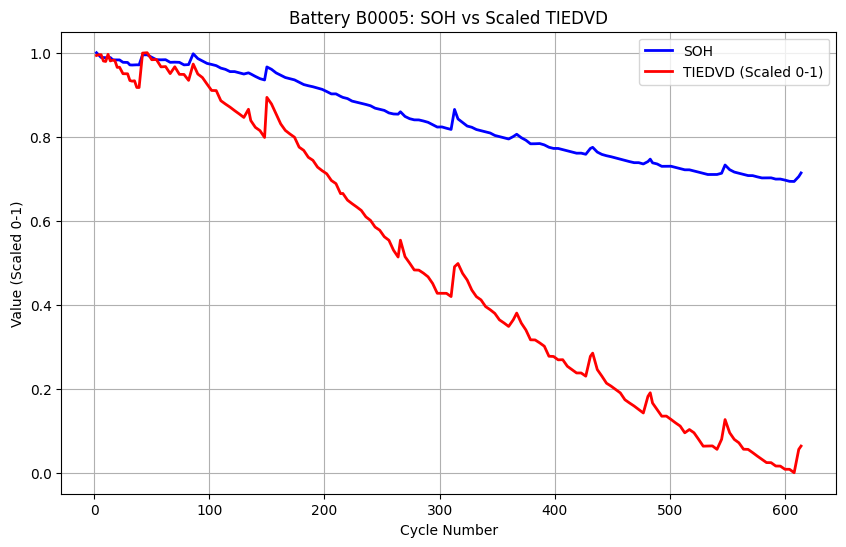

Plotting for Battery: B0006
  Plot saved to ../visualizations/B0006_soh_vs_tiedvd_scaled.png


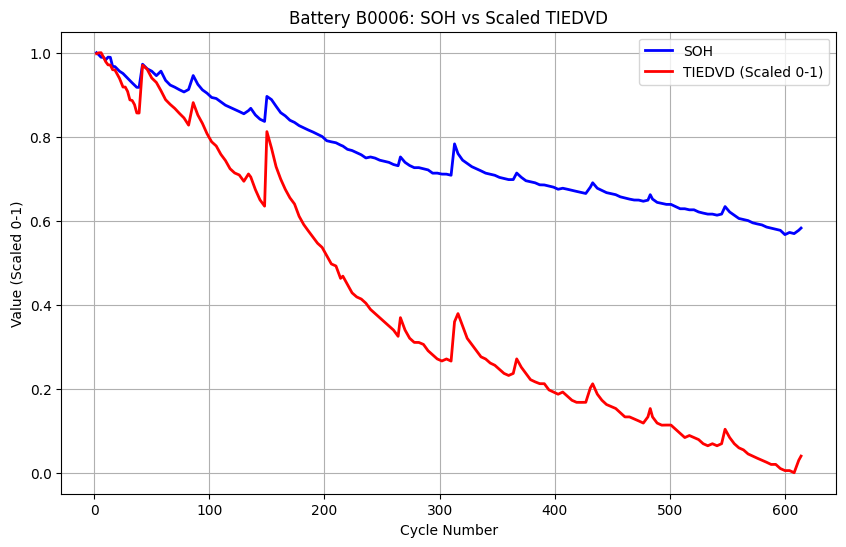

Plotting for Battery: B0018
  Plot saved to ../visualizations/B0018_soh_vs_tiedvd_scaled.png


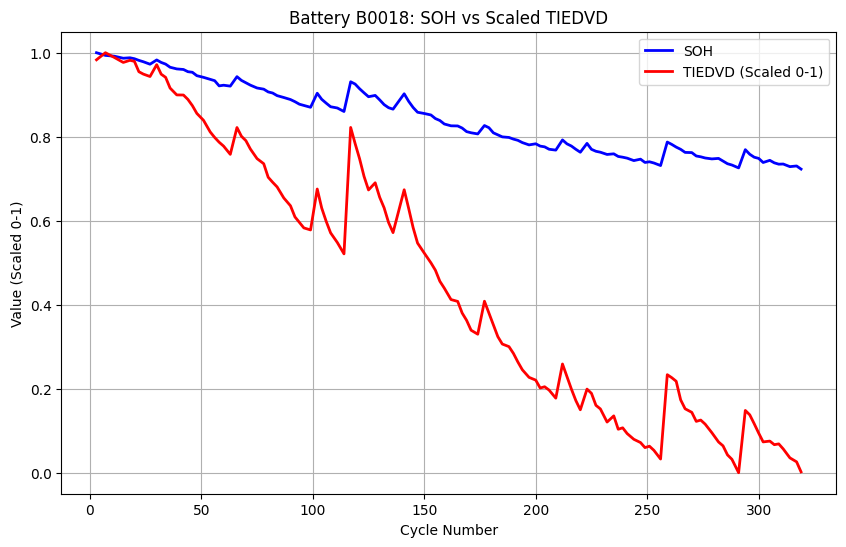


Individual battery plots generated.


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# --- Ensure 'cycle_summary' DataFrame exists from the previous cell ---
if 'cycle_summary' not in locals() or cycle_summary is None:
     raise ValueError("DataFrame 'cycle_summary' not found. Please run the previous cell.")

# Define visualization directory if not defined
if 'VISUALIZATION_DIR' not in locals():
    VISUALIZATION_DIR = '../visualizations/'
    os.makedirs(VISUALIZATION_DIR, exist_ok=True)


print("\n--- 10. Plotting SOH vs Scaled TIEDVD for Each Battery ---")

# Get unique battery IDs
battery_ids = cycle_summary['battery_id'].unique()

for batt_id in battery_ids:
    print(f"Plotting for Battery: {batt_id}")

    # Filter data for the current battery
    subset = cycle_summary[cycle_summary['battery_id'] == batt_id].copy()
    subset = subset.sort_values(by='cycle_number') # Ensure sorted by cycle

    if subset.empty or subset['tiedvd'].isnull().all():
        print(f"  Skipping {batt_id}, no valid data or TIEDVD found.")
        continue

    # --- Scale TIEDVD for this battery using Min-Max scaling ---
    min_tiedvd = subset['tiedvd'].min()
    max_tiedvd = subset['tiedvd'].max()

    # Avoid division by zero if TIEDVD is constant for a battery
    if max_tiedvd > min_tiedvd:
        subset['tiedvd_scaled'] = (subset['tiedvd'] - min_tiedvd) / (max_tiedvd - min_tiedvd)
    elif len(subset) > 0: # If only one point or all values are the same
        subset['tiedvd_scaled'] = 0.5 # Assign a midpoint value or handle as needed
    else:
        subset['tiedvd_scaled'] = np.nan # No data

    # --- Create the plot ---
    plt.figure(figsize=(10, 6))

    plt.plot(subset['cycle_number'], subset['soh'], label='SOH', linewidth=2, color='blue')
    plt.plot(subset['cycle_number'], subset['tiedvd_scaled'], label='TIEDVD (Scaled 0-1)', linewidth=2, color='red')

    plt.title(f'Battery {batt_id}: SOH vs Scaled TIEDVD')
    plt.xlabel('Cycle Number')
    plt.ylabel('Value (Scaled 0-1)')
    plt.ylim(-0.05, 1.05) # Set y-axis limits from 0 to 1 with a small margin
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = os.path.join(VISUALIZATION_DIR, f'{batt_id}_soh_vs_tiedvd_scaled.png')
    plt.savefig(plot_filename)
    print(f"  Plot saved to {plot_filename}")
    plt.show()

print("\nIndividual battery plots generated.")